In [22]:
from sklearn.datasets import make_circles
from sklearn.svm import SVC
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm

plt.style.use('ggplot')
%matplotlib inline
np.random.seed(0)

# Напоминание из теории

В случае оптимального байесовского классификатора разделяющая поверхность будет задаваться уравнением

$$
\mathbb{P}(C_1|x) = \mathbb{P}(C_2|x) \Longleftrightarrow \mathbb{P}(x|C_1)\mathbb{P}(C_1) = \mathbb{P}(x|C_2)\mathbb{P}(C_2).
$$

Теперь обсудим пример построения порождающей модели. Естественно, на основе нормального распределения или гауссианов. Пусть

$$
\mathbb{P}(x|C_i) = \mathbb{N}(x|\mu_i, \Sigma_i).
$$

Разделяющая поверхность будет иметь вид

$$
\ln \mathbb{P}(C_1) - \frac{1}{2}\ln |\Sigma_1| - \frac{1}{2}(x-\mu_1)^{T}\Sigma_1^{-1}(x-\mu_1) = \ln \mathbb{P}(C_2) - \frac{1}{2}\ln |\Sigma_2| - \frac{1}{2}(x-\mu_2)^{T}\Sigma_2^{-1}(x-\mu_2).
$$

Понятно, что разделяющая поверхность квадратичная. Для оценки параметров $\mu_i$ и $\Sigma_i$ имеет смысл использовать соответствующие выборочные характеристики (выборочное среднее и выборочная ковариационная матрица). Оценить $\mathbb{P}(C_i)$ можно долей числа элементов соответствующего класса.

# LDA

В рамках предположения, что $\Sigma_1 = \Sigma_2$ и

$$
\Sigma =  \frac{|C_1|}{|C_1| + |C_2|}\Sigma_1 + \frac{|C_2|}{|C_1| + |C_2|}\Sigma_2,
$$

где

$$
\Sigma_i = \frac{1}{|C_i|}\sum_{x\in C_i}\left(x-\mu_i\right)\left(x-\mu_i\right)^T
$$

разделяющая поверхность будет иметь вид гиперплоскости

$$
\left(\mu_2 - \mu_1\right)\Sigma^{-1}x + \frac{1}{2} \left(\mu_1^{T}\Sigma^{-1}\mu_1 - \mu_2^{T}\Sigma^{-1}\mu_2\right) + \ln \frac{\mathbb{P}(C_2)}{\mathbb{P}(C_1)} = 0.
$$

### Генерация данных

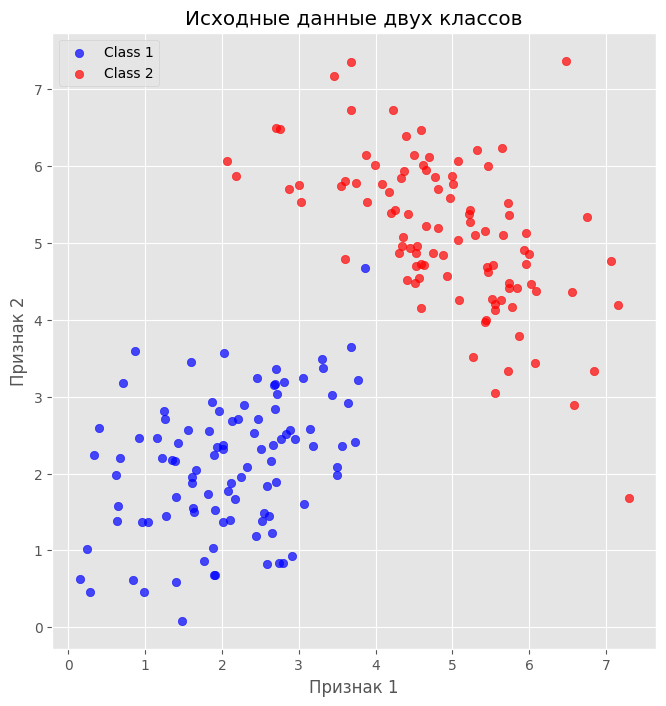

In [23]:
# 1. Генерация данных
np.random.seed(42)

class_1_size = 100
class_2_size = 100

class_1 = np.random.multivariate_normal(mean=[2, 2], cov=[[1, 0.5], [0.5, 1]], size=class_1_size)
class_2 = np.random.multivariate_normal(mean=[5, 5], cov=[[1, -0.5], [-0.5, 1]], size=class_2_size)

# Объединение данных
X = np.vstack((class_1, class_2))
y = np.hstack((np.zeros(100), np.ones(100)))

# Визуализация данных
plt.figure(figsize=(8,8))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.7)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.7)
plt.legend()
plt.title('Исходные данные двух классов')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.axis('scaled')
plt.show()

## Вычисление параметров модели

In [24]:
# Оценка среднего
def get_mu(class_objects):
    """
    Параметры
    ----------
    class_objects : {array-like} формы (n_samples, n_features)
        Объекты одного класса, где `n_samples` — число объектов
        и `n_features` — число признаков.

    Что возвращается
    -------
    mu : вектор из координат центроида класса
    """
    return np.mean(class_objects, axis=0)

mu_1 = get_mu(class_1)
mu_2 = get_mu(class_2)
assert np.isclose(mu_1, np.array([2.08307042, 2.11709274])).all() and np.isclose(mu_2, np.array([4.91067717, 5.13281048])).all()

In [25]:
# Обращенная матрица ковариаций
def get_Sigma_inv(class_1, class_2, mu_1, mu_2):
    """
    Параметры
    ----------
    class_1 : {array-like} формы (n_samples, n_features)
        Объекты класса 1, где `n_samples` — число объектов
        и `n_features` — число признаков.
    class_2 : {array-like} формы (n_samples, n_features)
        Объекты класса 2, где `n_samples` — число объектов
        и `n_features` — число признаков.
    mu_1 : {numpy.ndarray} — вектор из координат центроида класса 1
    mu_2 : {numpy.ndarray} — вектор из координат центроида класса 2

    Что возвращается
    -------
    Sigma_inv : обращенная общая матрица ковариаций
    """
    n1 = class_1.shape[0]
    n2 = class_2.shape[0]
    total = n1 + n2

    # Вычисляем ковариационные матрицы для каждого класса
    centered_1 = class_1 - mu_1
    Sigma_1 = (centered_1.T @ centered_1) / n1

    centered_2 = class_2 - mu_2
    Sigma_2 = (centered_2.T @ centered_2) / n2

    # Взвешенное усреднение
    Sigma = (n1 / total) * Sigma_1 + (n2 / total) * Sigma_2

    # Обращение матрицы
    Sigma_inv = np.linalg.inv(Sigma)

    return Sigma_inv

Sigma_inv = get_Sigma_inv(class_1, class_2, mu_1, mu_2)
assert np.isclose(Sigma_inv, np.array([[1.0782101, 0.18128796], [0.18128796, 1.19546925 ]])).all()

In [26]:
# Нормальный вектор гиперплоскости
def get_w(mu_1, mu_2, Sigma_inv):
    """
    Параметры
    ----------
    mu_1 : {numpy.ndarray} — вектор из координат центроида класса 1
    mu_2 : {numpy.ndarray} — вектор из координат центроида класса 2
    Sigma_inv : {numpy.ndarray} — обращенная общая матрица ковариаций

    Что возвращается
    -------
    w : нормальный вектор гиперплоскости
    """
    return Sigma_inv @ (mu_2 - mu_1)

w = get_w(mu_1, mu_2, Sigma_inv)
assert np.isclose(w, np.array([3.59546745, 4.11780887])).all()

In [27]:
# Коэффициент смещения гиперплоскости
def get_b(mu_1, mu_2, Sigma_inv, class_1_size, class_2_size):
    """
    Параметры
    ----------
    mu_1 : {numpy.ndarray} — вектор из координат центроида класса 1
    mu_2 : {numpy.ndarray} — вектор из координат центроида класса 2
    Sigma_inv : {numpy.ndarray} — обращенная общая матрица ковариаций
    class_1_size : {int} — количество элементов класса 1
    class_2_size : {int} — количество элементов класса 2

    Что возвращается
    -------
    b : коэффициент смещения гиперплоскости
    """
    # Априорные лог-вероятности
    P_C2 = class_2_size / (class_1_size + class_2_size)
    P_C1 = class_1_size / (class_1_size + class_2_size)
    log_prior_ratio = np.log(P_C2 / P_C1)

    # Квадратичные члены
    mu1_S_inv_mu1 = mu_1 @ Sigma_inv @ mu_1
    mu2_S_inv_mu2 = mu_2 @ Sigma_inv @ mu_2

    # Смещение
    b = 0.5 * (mu1_S_inv_mu1 - mu2_S_inv_mu2) + log_prior_ratio

    return b

b = get_b(mu_1, mu_2, Sigma_inv, class_1_size, class_2_size)
assert np.isclose(b, -27.499753803149826)

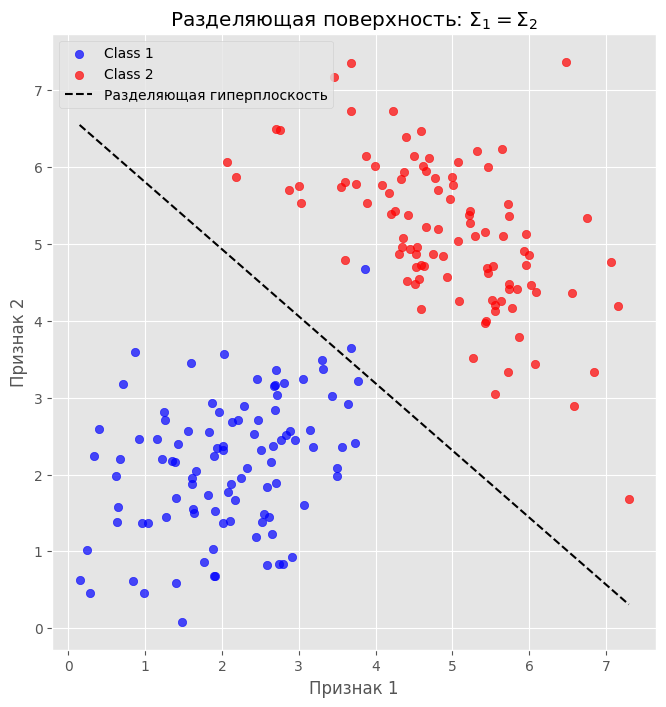

In [28]:
# Построение разделяющей прямой
x_vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)

# Координаты y для гиперплоскости
y_vals = -(w[0] * x_vals + b) / w[1]

# Визуализация
plt.figure(figsize=(8,8))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.7)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.7)
plt.plot(x_vals, y_vals, label='Разделяющая гиперплоскость', color='black', linestyle = "--")
plt.legend()
plt.title('Разделяющая поверхность: $\\Sigma_1 = \\Sigma_2$')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.axis('scaled')
plt.show()

Если к данным добавить фиктивный столбец из единиц и в начало вектора весов добавить коэффициент, отвечающий за смещение, то классификатор будет выглядеть следующим образом

In [29]:
X_stacked = np.hstack((np.array([1]*len(X)).reshape(-1,1), X))
W_stacked = np.hstack((b,w))

def predict(sample, W):
    result = sample @ W
    if result < 0:
        return 1
    return 2

In [30]:
# Тестовый объект 1
sample_1 = np.array([1,3,2])
# Предсказание класса
predict(sample_1, W_stacked)

1

In [31]:
# Тестовый объект 2
sample_2 = np.array([1,6,5])
# Предсказание класса
predict(sample_2, W_stacked)

2

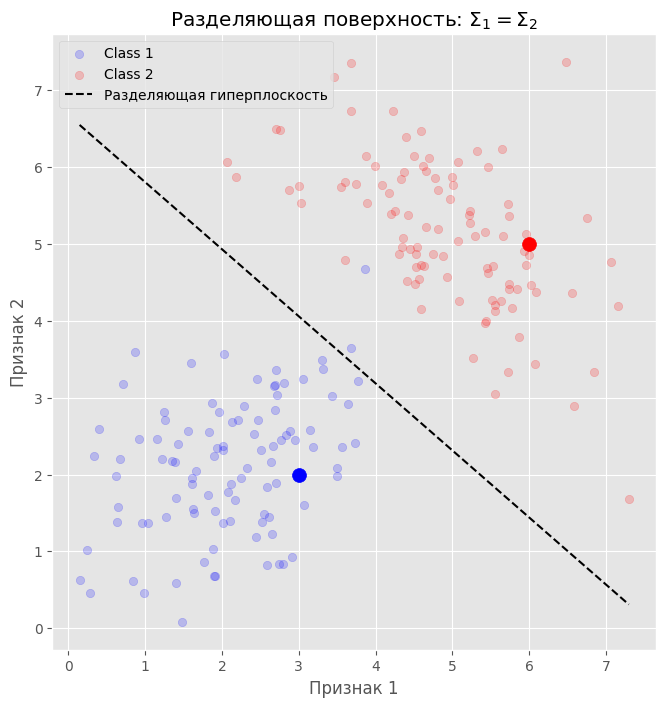

In [32]:
# Визуализация
plt.figure(figsize=(8,8))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.2)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.2)
plt.scatter(sample_1[1], sample_1[2], s=100, c='blue')
plt.scatter(sample_2[1], sample_2[2], s=100, c='red')
plt.plot(x_vals, y_vals, label='Разделяющая гиперплоскость', color='black', linestyle = "--")
plt.legend()
plt.title('Разделяющая поверхность: $\\Sigma_1 = \\Sigma_2$')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.axis('scaled')
plt.show()

# QDA

Напомним выражение для резделяющей поверхности:

$$
\ln \mathbb{P}(C_1) - \frac{1}{2}\ln |\Sigma_1| - \frac{1}{2}(x-\mu_1)^{T}\Sigma_1^{-1}(x-\mu_1) = \ln \mathbb{P}(C_2) - \frac{1}{2}\ln |\Sigma_2| - \frac{1}{2}(x-\mu_2)^{T}\Sigma_2^{-1}(x-\mu_2).
$$

Будем называть каждую из частей уравнения **дискриминантной функцией** класса $1$ и $2$ соответственно.

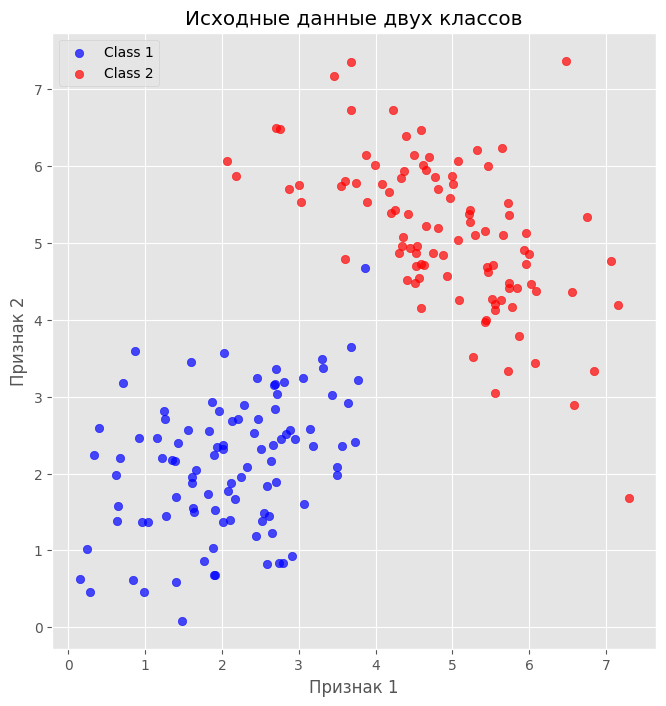

In [33]:
# Генерация данных
np.random.seed(42)

class_1_size = 100
class_2_size = 100

class_1 = np.random.multivariate_normal(mean=[2, 2], cov=[[1, 0.5], [0.5, 1]], size=class_1_size)
class_2 = np.random.multivariate_normal(mean=[5, 5], cov=[[1, -0.5], [-0.5, 1]], size=class_2_size)

# Объединение данных
X = np.vstack((class_1, class_2))
y = np.hstack((np.zeros(100), np.ones(100)))

# Визуализация данных
plt.figure(figsize=(8,8))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.7)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.7)
plt.legend()
plt.title('Исходные данные двух классов')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.axis('scaled')
plt.show()

## Вычисление параметров модели

In [34]:
# Оценка среднего
def get_mu(class_objects):
    """
    Параметры
    ----------
    class_objects : {array-like} формы (n_samples, n_features)
        Объекты одного класса, где `n_samples` — число объектов
        и `n_features` — число признаков.

    Что возвращается
    -------
    mu : вектор из координат центроида класса
    """
    return np.mean(class_objects, axis=0)


mu_1 = get_mu(class_1)
mu_2 = get_mu(class_2)
assert np.isclose(mu_1, np.array([2.08307042, 2.11709274])).all() and np.isclose(mu_2, np.array([4.91067717, 5.13281048])).all()

In [35]:
# Внутриклассовая матрица ковараций
def get_Sigma(class_elements, mu):
    """
    Параметры
    ----------
    class_elements : {array-like} формы (n_samples, n_features)
        Объекты данного класса, где `n_samples` — число объектов
        и `n_features` — число признаков.
    mu : {numpy.ndarray} — вектор из координат центроида данного класса

    Что возвращается
    -------
    Sigma : матрица ковариаций данного класса
    """
    centered = class_elements - mu       # центрирование
    n = centered.shape[0]                # число объектов
    return (centered.T @ centered) / n

Sigma_1 = get_Sigma(class_1, mu_1)
Sigma_2 = get_Sigma(class_2, mu_2)
assert np.isclose(Sigma_1, np.array([[0.8150929 , 0.29751939],[0.29751939, 0.76768711]])).all() and np.isclose(Sigma_2, np.array([[ 1.08836645, -0.58617111], [-0.58617111,  0.94906895]])).all()

In [36]:
# Оценка вероятностей классов
def get_prior(class_1, class_2):
    """
    Параметры
    ----------
    class_1 : {array-like} формы (n_samples, n_features)
        Объекты класса 1, где `n_samples` — число объектов
        и `n_features` — число признаков.
    class_2 : {array-like} формы (n_samples, n_features)
        Объекты класса 2, где `n_samples` — число объектов
        и `n_features` — число признаков.

    Что возвращается
    -------
    (prior_1, prior_2) : кортеж, состоящий из оценок вероятностей классов 1 и 2
    """
    n1 = len(class_1)
    n2 = len(class_2)
    total = n1 + n2
    return (n1 / total, n2 / total)

prior_1, prior_2 = get_prior(class_1, class_2)
assert np.isclose(np.array([prior_1, prior_2]), np.array([0.5, 0.5])).all()

In [37]:
# Вычисление дискриминантной функции
def get_discriminant(x, Sigma, mu, prior):
    """
    Параметры
    ----------
    x : {array-like} вектор n_features
        Один объект данных, где `n_features` — число признаков.
    Sigma : матрица ковариаций данного класса
    mu : {numpy.ndarray} — вектор из координат центроида данного класса
    prior : оценка вероятности данного класса

    Что возвращается
    -------
    discriminant : значение дискриминантной функции для данного класса в точке x
    """
    x = np.array(x)
    mu = np.array(mu)
    diff = x - mu

    # Обращение матрицы и определитель
    Sigma_inv = np.linalg.inv(Sigma)
    det_Sigma = np.linalg.det(Sigma)

    # Логарифм априорной вероятности
    log_prior = np.log(prior)

    # Логарифм определителя
    log_det = np.log(det_Sigma)

    # Квадратичная форма (скаляр)
    exponent = diff @ Sigma_inv @ diff

    # Дискриминантная функция
    discriminant = log_prior - 0.5 * log_det - 0.5 * exponent

    return discriminant

assert np.isclose(get_discriminant(X[0], Sigma_1, mu_1, prior_1), -0.6600206493124732)

  0%|          | 0/200 [00:00<?, ?it/s]

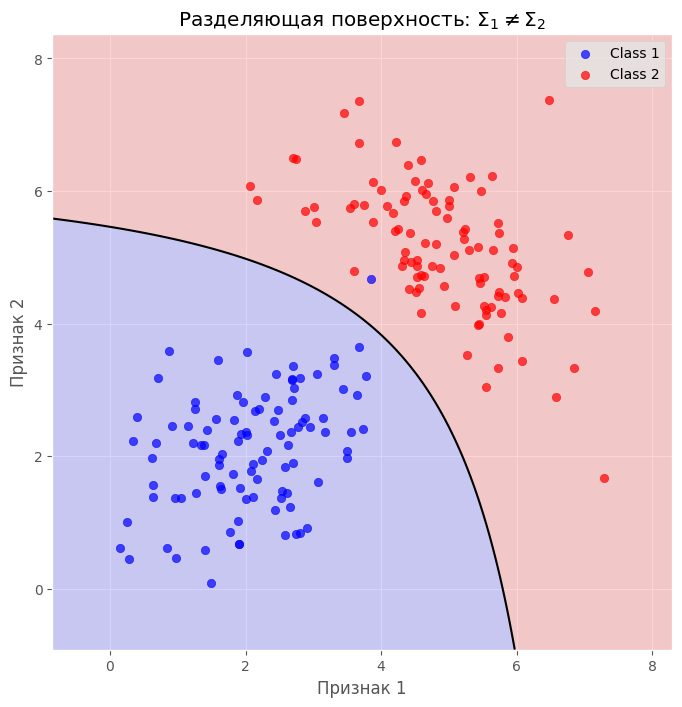

In [38]:
# Создание сетки для визуализации разделяющей поверхности
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Вычисление квадратичного уравнения для каждой точки сетки
Z = np.zeros_like(xx)
for i in tqdm(range(xx.shape[0])):
    for j in range(xx.shape[1]):
        x = np.array([xx[i, j], yy[i, j]])

        # Разница дискриминантных функций
        Z[i, j] = get_discriminant(x, Sigma_1, mu_1, prior_1) - get_discriminant(x, Sigma_2, mu_2, prior_2)

# Построение графика разделяющей кривой
plt.figure(figsize=(8,8))
plt.contourf(xx, yy, Z, levels=0, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']), alpha=0.5)
plt.contour(xx, yy, Z, levels=[0], colors='black')
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.7)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.7)
plt.legend()
plt.title('Разделяющая поверхность: $\\Sigma_1 \\neq \\Sigma_2$')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.show()

# SVM

Реализуйте `kernel SVM` с ипользованием пакета `optimize` с использованием полиномиального ядра. Продемонстрируйте результаты, сравните с библиотечным вариантом, на наборе данных типа концентрических окружностей

In [39]:
# Генерация данных: концентрические окружности
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=42)
y = 2 * y - 1  # переводим метки в -1 и +1

# Нормализуем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
# 1. Полиномиальное ядро
def polynomial_kernel(X1, X2, degree=2, gamma=1, coef=0):
    return (gamma * np.dot(X1, X2.T) + coef) ** degree

# 2. Решение двойственной задачи с помощью scipy.optimize
def train_kernel_svm(X, y, kernel_func, C=1.0, **kernel_params):
    n_samples = X.shape[0]

    # Вычисляем матрицу ядра
    K = kernel_func(X, X, **kernel_params)

    # Умножаем на y_i * y_j
    P = y[:, None] * y[None, :] * K  # матрица для целевой функции

    # Целевая функция: 0.5 * alpha^T P alpha - sum(alpha)
    def objective(alpha):
        return 0.5 * alpha @ P @ alpha - np.sum(alpha)

    # Градиент
    def grad_objective(alpha):
        return P @ alpha - 1

    # Ограничения
    # Условие: y^T @ alpha = 0
    A = y.reshape(1, -1)
    constraints = {'type': 'eq', 'fun': lambda alpha: A @ alpha, 'jac': lambda alpha: A}

    # Ограничения: 0 <= alpha <= C
    bounds = [(0, C) for _ in range(n_samples)]

    # Начальное приближение
    alpha0 = np.zeros(n_samples)

    # Решаем
    result = minimize(objective, alpha0, method='SLSQP', bounds=bounds,
                      constraints=constraints, jac=grad_objective, options={'disp': False})

    alpha = result.x

    # Находим опорные векторы
    sv_idx = (alpha > 1e-5)
    alpha_sv = alpha[sv_idx]
    X_sv = X[sv_idx]
    y_sv = y[sv_idx]

    # Вычисляем b
    # используем среднее по опорным векторам
    K_sv = kernel_func(X_sv, X_sv, **kernel_params)
    b = np.mean(y_sv - (alpha_sv * y_sv) @ K_sv)

    return alpha_sv, X_sv, y_sv, b, sv_idx

# 3. Предсказание
def predict_kernel_svm(X_test, X_sv, y_sv, alpha_sv, b, kernel_func, **kernel_params):
    K_test = kernel_func(X_test, X_sv, **kernel_params)
    y_pred = K_test @ (alpha_sv * y_sv) + b
    return np.sign(y_pred), y_pred

In [41]:
# Параметры ядра
kernel_params = {'degree': 2, 'gamma': 1, 'coef': 0}

# Обучение модели
alpha_sv, X_sv, y_sv, b, sv_idx = train_kernel_svm(X_scaled, y, polynomial_kernel, C=1.0, **kernel_params)

# Предсказания
y_pred_ours, _ = predict_kernel_svm(X_scaled, X_sv, y_sv, alpha_sv, b, polynomial_kernel, **kernel_params)
acc_ours = accuracy_score(y, y_pred_ours)

# Сравнение с sklearn
clf_sklearn = SVC(kernel='poly', degree=2, gamma=1, coef0=0, C=1.0)
clf_sklearn.fit(X_scaled, y)
y_pred_sk = clf_sklearn.predict(X_scaled)
acc_sk = accuracy_score(y, y_pred_sk)

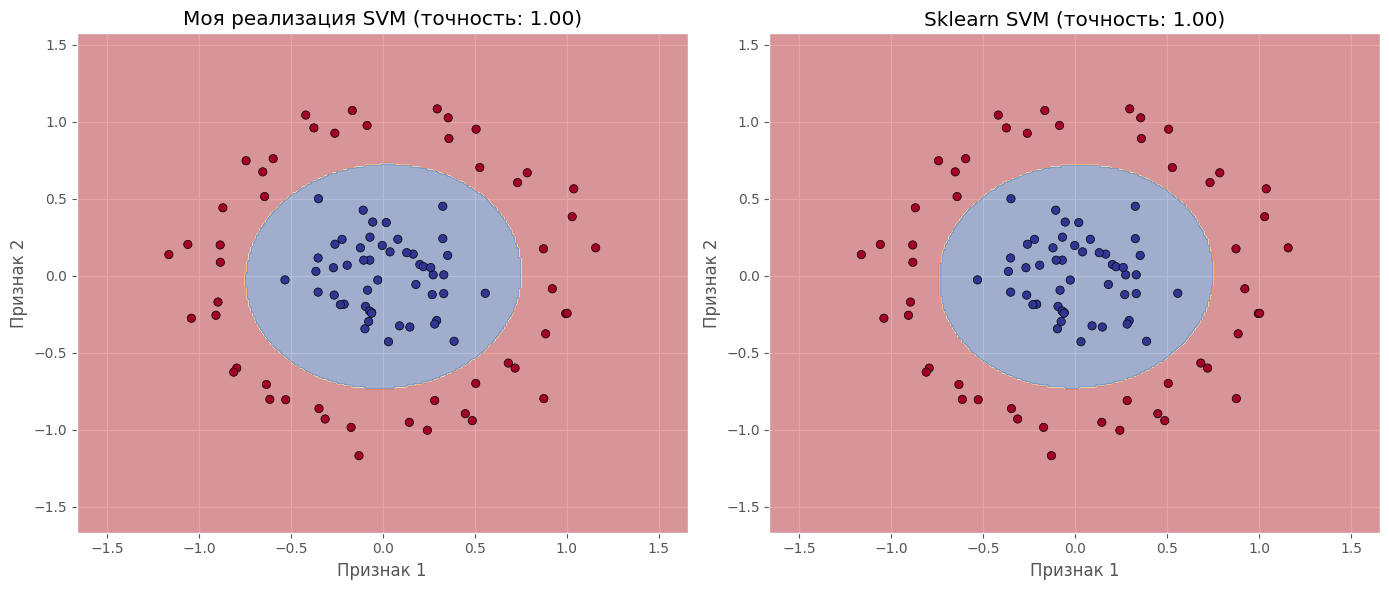

In [42]:
# Визуализация
def plot_decision_boundary(X, y, model=None, sklearn_model=None, scaler=None):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    if scaler:
        grid = scaler.transform(grid)

    if model == 'our_svm':
        Z, _ = predict_kernel_svm(grid, X_sv, y_sv, alpha_sv, b, polynomial_kernel, **kernel_params)
    elif sklearn_model:
        Z = sklearn_model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='k')
    plt.title("Разделяющая поверхность")
    plt.xlabel("Признак 1")
    plt.ylabel("Признак 2")

plt.figure(figsize=(14, 6))

# Моя модель
plt.subplot(1, 2, 1)
plot_decision_boundary(X, y, model='our_svm', scaler=scaler)
plt.title(f"Моя реализация SVM (точность: {acc_ours:.2f})")

# Sklearn
plt.subplot(1, 2, 2)
plot_decision_boundary(X, y, sklearn_model=clf_sklearn, scaler=scaler)
plt.title(f"Sklearn SVM (точность: {acc_sk:.2f})")

plt.tight_layout()
plt.show()